<h1><center>LINMA2472 : Project 2 - part 2, Random Fourier Features </center></h1>

$\textbf{Author}$: Remi Delogne, remi.delogne@uclouvain.be

Import the following packages and functions. Refer to their documentation on the internet for more information on installation and usage.


In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import accuracy_score
from math import pi, sqrt, cos

from keras.datasets import mnist #Contains the dataset
from matplotlib import pyplot
import matplotlib.pyplot as plt

import time #Used to find the execution time of a part of the code

from IPython.display import display, HTML #For visual comfort
display(HTML("<style>.container { width:80% !important; }</style>"))

2022-11-13 10:00:44.382647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 10:00:44.563205: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-13 10:00:44.573313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-13 10:00:44.573350: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

11490434/11490434 [==============================] - 2s 0us/step


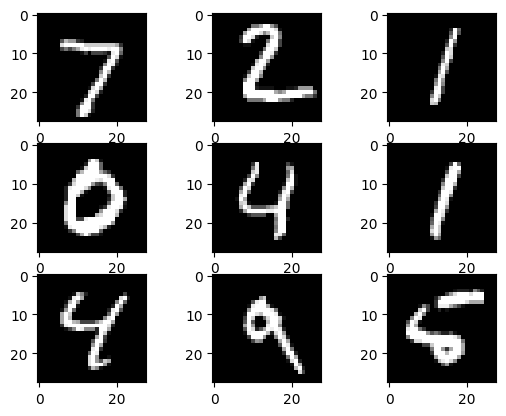

(10000, 784)


In [2]:
# load dataset and rescale the data to [0,15]
''' load dataset: (we use the larger subset for testing and the smaller 
for training to demonstrate the efficiency of evaluating of new instances with RFF)'''
(testX,testy),(trainX,trainy) = mnist.load_data()
#Rescaling
trainX = np.floor(trainX/16)
testX = np.floor(testX/16)
#Plot some images, for fun
for i in range(9):
    pyplot.subplot(330+1+i)
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

#Put the data in vector form
trainX=trainX.reshape((10000,-1))
testX=testX.reshape((60000,-1))

print(trainX.shape)

### Use the *time* package functions to time the executions of parts of your code:

In [3]:
#Example of timing a piece of code
tik=time.perf_counter() # Start
for i in range (1000000):
    i=i+1
tok=time.perf_counter() # Finish
print(f'Total time: {tok-tik:.3f} seconds')#prints the result to 3 decimal places

Total time: 0.089 seconds


### Train a linear SVM on the training data and evaluate it on the testing data
Use the tik-tok method to see how long the classifier takes to evaluate the 60.000 testing instances.

Use the accuracy metric to judge the quality of your classifier.

In [4]:
#Define the classifier
clfLin=svm.SVC(kernel="linear")

#Train the classifier
tik = time.perf_counter() # Start measuring training time
clfLin.fit(trainX,trainy)
tok = time.perf_counter() # Stop measuring training time
linear_training_time = tok - tik

#Evaluate its accuracy
tik = time.perf_counter()
predicted=clfLin.predict(testX)
score_linear=accuracy_score(testy,predicted)
tok = time.perf_counter()
linear_testing_time = tok - tik

print(f"Training finished in {linear_training_time:.3f} seconds,")
print(f"Testing Finished in {linear_testing_time:.3f} seconds with accuracy of {score_linear:.3f}.")

Training finished in 4.193 seconds,
Testing Finished in 38.701 seconds with accuracy of 0.907.


### Train a Kernel SVM with the Gaussian Kernel on the training data and evaluate it on the testing data
Use the tik-tok method to see how long the classifier takes to evaluate the $60000$ testing instances.

Use the accuracy metric to judge the quality of your classifier.

You may stick to the default parameters of sci-kit learn.

In [5]:
#Define the classifier
clfKernel=svm.SVC(kernel='rbf')
#Train it
tik = time.perf_counter()
clfKernel.fit(trainX, trainy)
tok = time.perf_counter()
rbf_training_time = tok - tik

#Use it
tik = time.perf_counter()
predicted=clfKernel.predict(testX)
score_rbf=accuracy_score(testy,predicted)
tok = time.perf_counter()
rbf_testing_time = tok - tik

print(f"Training finished in {rbf_training_time:.3f} seconds,")
print(f"Testing Finished in {rbf_testing_time:.3f} seconds with accuracy of {score_rbf:.3f}.")

Training finished in 7.506 seconds,
Testing Finished in 132.762 seconds with accuracy of 0.956.


### *TO DO*: Use the following functions to implement Random Fourier Features

You are here going to try to approximate the Gaussian kernel used in the second classfier.

Use the first function to generate your $\boldsymbol\omega_i$ (using an appropriate distribution) and your $b_i$ (using appropriate distributions), this should return $D$ vectors $\boldsymbol\omega_i\in\mathbb R^d$ (in the form of a matrix for example) and $D$ values $b_i\in[0,2\pi]$. 

Use the second function to create the mapping $\boldsymbol z(\boldsymbol x)$ as described in the slides.

In [6]:
def generate_freq(X, D, std=1):
    '''
    shape X: (n,d)
    shape W: (D, d)
    shape b: (D,1)
    
    => W.T @ x = (D,d)x(d,1) = (D,1)
    '''
    d = X.shape[1]
    
    W = np.random.normal(loc=0, scale=std, size=(D,d))
    b = np.random.uniform(0 , 2*pi, size=(D,1))
    return W,b

def transform(X, W,b):
    '''
    shape X: (n,d)
    shape W: (D, d)
            WX => (D,n)
    shape b: (D,1)

    Z.shape = (D x 1) verif: 
    '''
    D = W.shape[0]
    Z = sqrt(2/D)*( np.cos( W@X.T + b ) ).T
    return Z


### *TO DO*: Transform your trainX and testX

Use the function you defined to transform your data.

Make sure you only generate $\boldsymbol W$ and $\boldsymbol b$ once.

Use a standard deviation of $\frac{1}{100}$ et $D=300$ random features to start with.

You may also use the tik-tok method to time the procedure of creating Random features.

In [7]:
D=300      #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

tik = time.perf_counter()
W,b = generate_freq(trainX,D, std=sigma)

trainX_rff = transform(trainX , W, b) # n = 10 000
testX_rff  = transform(testX , W, b)  # n = 60 000

tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")


RFF transformation time : 2.483 seconds.


In [8]:
#Sanity check, do the dimensions of your transformations match your expectation?
#Bear in mind that there are more instances in the test set than in the trianing set here
print(f"Dimension of trainX after transformation : {trainX_rff.shape}.")
print(f"Dimension of testX after transformation : {testX_rff.shape}.")

Dimension of trainX after transformation : (10000, 300).
Dimension of testX after transformation : (60000, 300).


### Use another linear SVM to classify the transformed data
Now that the instances have been transformed, theory tells us that they are much more ameneable to linear classification than before.

In [9]:
#Define the classifier
clfRff = svm.SVC(kernel="linear",C=np.inf)

#Train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter() 
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#Use it
tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds; Accuracy: {score_rff:.3f}")

Training Finished in 2.810 seconds
Testing Finished in 20.160 seconds; Accuracy: 0.891


### Additional workspace 

Investigate the relationship between $D$ and the accuracy of the classifier.

In [10]:
d_values=[10,100,250,500,750,784,1000]
accuracy=[]
transform_time = []
train_time = []
test_time = []


In [11]:
for i in range(len(d_values)):
    D = d_values[i]
    print('--- ' + str(D) + ' ---')
    # Transform time
    tik = time.perf_counter()
    W,b = generate_freq(trainX, D, std=sigma)
    trainX_rff = transform(trainX , W, b) # n = 10 000
    testX_rff  = transform(testX , W, b)  # n = 60 000
    tok = time.perf_counter()
    tiktok = tok - tik
    print("transform_time: " + str(tiktok))
    transform_time.append(tiktok)

    #Define the classifier
    clfRff = svm.SVC(kernel="linear")

    #Train it
    tik = time.perf_counter()

    clfRff.fit(trainX_rff, trainy)

    tok = time.perf_counter()
    tiktok=tok-tik
    print("train_time: " + str(tiktok))
    train_time.append(tiktok)

    # Test it
    tik = time.perf_counter()
    predicted = clfRff.predict(testX_rff)

    score_rff = accuracy_score(testy,predicted)
    tok = time.perf_counter()
    tiktok=tok-tik
    print("test_time: " + str(tiktok))
    test_time.append(tiktok)
    accuracy.append(score_rff)
    print(f"Accuracy with D={D:.1f}: {score_rff:.3f}\n\n")

--- 10 ---
transform_time: 0.47983121799188666
train_time: 2.489903558016522
test_time: 16.065965418994892
Accuracy with D=10.0: 0.375


--- 100 ---
transform_time: 1.6672840930114035
train_time: 2.0776427329983562
test_time: 13.809373888012487
Accuracy with D=100.0: 0.843


--- 250 ---
transform_time: 2.3823906579928007
train_time: 3.1220750549982768
test_time: 23.4912014589936
Accuracy with D=250.0: 0.909


--- 500 ---
transform_time: 3.1501590260013472
train_time: 4.266007391997846
test_time: 38.01825562198064
Accuracy with D=500.0: 0.933


--- 750 ---
transform_time: 5.122037322988035
train_time: 6.178686703991843
test_time: 68.82047225299175
Accuracy with D=750.0: 0.939


--- 784 ---
transform_time: 3.4461957000021357
train_time: 7.232398734020535
test_time: 69.08490849199006
Accuracy with D=784.0: 0.939


--- 1000 ---
transform_time: 5.928100263001397
train_time: 8.40354120102711
test_time: 77.59811696200632
Accuracy with D=1000.0: 0.943




### Don't forget to add plots and other nice things

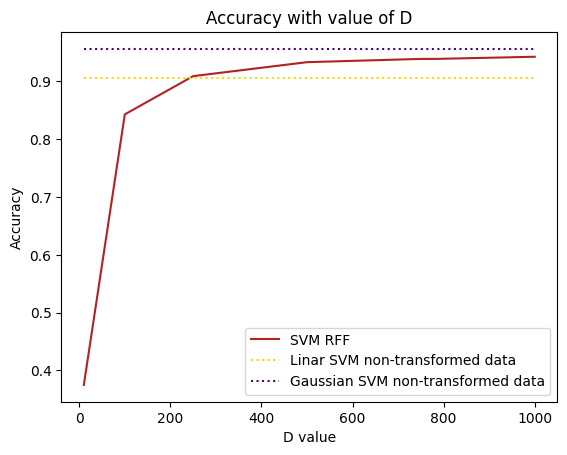

In [12]:
plt.figure()
plt.plot(d_values, accuracy, label='SVM RFF', c='firebrick')
plt.plot(d_values,np.repeat(score_linear, len(d_values)), label='Linar SVM non-transformed data', linestyle='dotted', c='gold')
plt.plot(d_values,np.repeat(score_rbf, len(d_values)), label='Gaussian SVM non-transformed data', linestyle='dotted', c='indigo')
plt.title("Accuracy with value of D")
plt.xlabel("D value")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

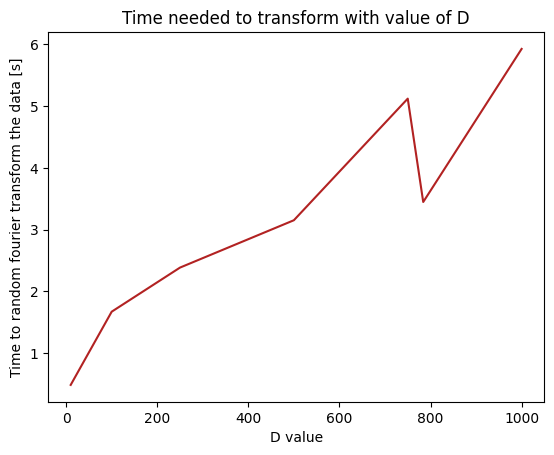

In [13]:
plt.figure()
plt.plot(d_values, transform_time, c='firebrick')
plt.title("Time needed to transform with value of D")
plt.xlabel("D value")
plt.ylabel('Time to random fourier transform the data [s]')
plt.show()

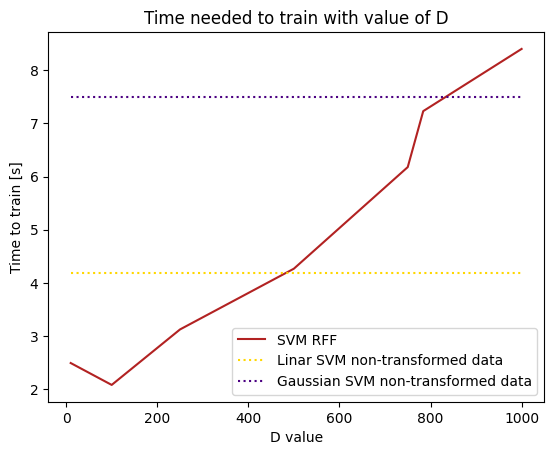

In [14]:
plt.figure()
plt.plot(d_values, train_time, label='SVM RFF',c='firebrick')
plt.plot(d_values,np.repeat(linear_training_time, len(d_values)), label='Linar SVM non-transformed data', linestyle='dotted', c='gold')
plt.plot(d_values,np.repeat(rbf_training_time, len(d_values)), label='Gaussian SVM non-transformed data', linestyle='dotted', c='indigo')
plt.title("Time needed to train with value of D")
plt.xlabel("D value")
plt.ylabel('Time to train [s]')
plt.legend()
plt.show()

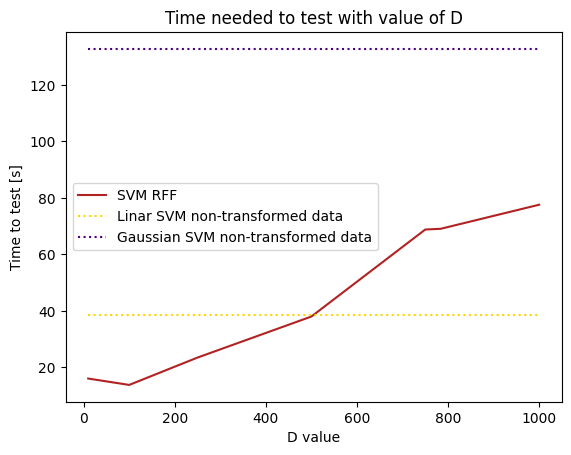

In [15]:
plt.figure()
plt.plot(d_values, test_time, label='SVM RFF', c='firebrick')
plt.plot(d_values,np.repeat(linear_testing_time, len(d_values)), label='Linar SVM non-transformed data', linestyle='dotted', c='gold')
plt.plot(d_values,np.repeat(rbf_testing_time, len(d_values)), label='Gaussian SVM non-transformed data', linestyle='dotted', c='indigo')
plt.title("Time needed to test with value of D")
plt.xlabel("D value")
plt.ylabel('Time to test [s]')
plt.legend()
plt.show()

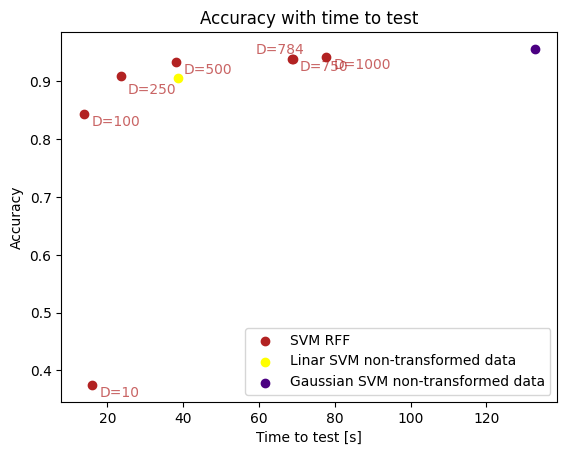

In [16]:
plt.figure()
plt.scatter(test_time,accuracy, label='SVM RFF', c='firebrick')
plt.scatter(linear_testing_time, score_linear, label='Linar SVM non-transformed data', c='yellow' )
plt.scatter(rbf_testing_time, score_rbf, label='Gaussian SVM non-transformed data',c='indigo' )
for i in range(len(d_values)):
    if d_values[i] == 784:
        plt.annotate('D=' + str(d_values[i]), (test_time[i]-10,accuracy[i]+0.008), c='firebrick', alpha=0.7)
    elif d_values[i] == 250:
        plt.annotate('D=' + str(d_values[i]), (test_time[i]+2,accuracy[i]-0.03), c='firebrick', alpha=0.7)
    else:
        plt.annotate('D=' + str(d_values[i]), (test_time[i]+2,accuracy[i]-0.02), c='firebrick', alpha=0.7)
plt.title("Accuracy with time to test")
plt.xlabel("Time to test [s]")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a9ed9f84-fe38-4268-9cae-f8232cc183f9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>